<a href="https://colab.research.google.com/github/AtufaShireen/DevOpsChallenge/blob/main/DevOpsChallenge/cust_seg_ltv_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# use below code to convert the 'exponential' values to float
np.set_printoptions(suppress=True)
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [ ]:
!pip install Lifetimes==0.11.1
!pip install scikit-learn-extra
!pip install squarify

In [ ]:
import pandas as pd
import lifetimes
import matplotlib.pyplot as plt
import squarify
import numpy as np
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_transaction_rate_heterogeneity,plot_frequency_recency_matrix,plot_probability_alive_matrix
from lifetimes import GammaGammaFitter,BetaGeoFitter

# RFM SEGMENTATION
Recency : Time since last order

Frequency : Total number of transactions

Monetary : Total transactions value

# ML-DL-PLAYGROUND

In [ ]:
#@title rfma
from datetime import date
from datetime import datetime
def abstract_rfma_df(req_df,id_col,trans_col=None,trans_date_col=None,recency_col=None,frequency_col=None,monetary_col=None,age_col=None,cal_rec=None,cal_freq=None,cal_mon=None):
    req_df.dropna(inplace=True)
    df = req_df.copy()
    new_df = df.groupby([id_col],as_index=False)[id_col].first()
    new_df.columns = ['cust_id']

    if trans_date_col!=None:
        df[trans_date_col] = pd.to_datetime(df[trans_date_col],infer_datetime_format=True).dt.normalize()
        dates_df = df.groupby(by=id_col,
                                as_index=False)[trans_date_col].agg(['min','max']).reset_index()
        dates_df.columns = ['cust_id', 'FirstPurchaseDate','LastPurchaseDate']

    if age_col!=None:
        new_df['uniq_age'] = df[age_col] 

    elif (age_col==None) & (trans_date_col!=None):
        print('herer (age_col==None) & (trans_date_col!=None)')
        last_date = max(dates_df['LastPurchaseDate'])
        dates_df['uniq_age'] = last_date - dates_df['FirstPurchaseDate']
        new_df['uniq_age'] = dates_df['uniq_age'].dt.days

    if cal_rec!=None:
        new_df['uniq_rec'] = df[cal_rec]
        new_df['recency'] = df[cal_rec]

    elif (recency_col ==None)& (trans_date_col!=None):
        print('herer (rececncy_col==None) & (trans_date_col!=None)')
        recent_date = max(df[trans_date_col])
        new_df['recency'] = pd.to_numeric(dates_df['LastPurchaseDate'].apply(lambda x: (recent_date - x)).dt.days, downcast='integer')
        new_df['uniq_rec']=(dates_df['LastPurchaseDate']-dates_df['FirstPurchaseDate']).dt.days
    elif (recency_col!=None):
        new_df['uniq_rec']=(new_df['uniq_age']-df[recency_col])
        new_df['recency'] = df[recency_col]


    if cal_freq!=None:
        new_df['uniq_freq'] = df[cal_freq]
        new_df['frequency'] = df[cal_freq]

    elif (frequency_col ==None)& (trans_date_col!=None):
        print('herer (frequnecy_col==None) & (trans_date_col!=None)')
        frequency_df = df.drop_duplicates().groupby(
        by=[id_col], as_index=False)[trans_date_col].count()
        frequency_df.columns = ['cust_id', 'frequency']
        
        uni_freq_df = df.drop_duplicates().groupby(
        by=[id_col], as_index=False)[trans_date_col].nunique()

        uni_freq_df.columns = ['cust_id', 'uniq_freq']
        uni_freq_df['uniq_freq']=uni_freq_df['uniq_freq']

        new_df['frequency'] =frequency_df['frequency']
        new_df['uniq_freq'] =uni_freq_df['uniq_freq']-1
        # uni_freq_df['uniq_freq']=uni_freq_df['uniq_freq'] -1
    else:
        new_df['frequency'] =df[frequency_col]
        new_df['uniq_freq'] =df[frequency_col]-1

    if cal_mon!=None:
        new_df['monetary'] = df[cal_mon]
        new_df['uniq_mon'] = df[cal_mon]
    elif monetary_col ==None:
        print('herer (monetary_col==None) & (trans_date_col!=None)')
        monetary_df = df.groupby(by=id_col, as_index=False)[trans_col].sum()
        monetary_df.columns = ['cust_id', 'monetary']
        monetary_df['uniq_mon'] = monetary_df['monetary'] / (new_df['frequency'])
        monetary_df.fillna(0,inplace=True)
        monetary_df[monetary_df['uniq_mon']< 0 ] = 0
        new_df[['monetary','uniq_mon']] = monetary_df[['monetary','uniq_mon']]
    else:
        new_df['monetary'] = df[monetary_col]
        new_df['uniq_mon'] = df[monetary_col] / new_df['frequency']
    

    # rfm_df =  recency_df.merge(frequency_df,on='cust_id')
    # rfm_df = rfm_df.merge(monetary_df, on='cust_id')
    # rfm_df = rfm_df.merge(uni_freq_df, on='cust_id')
    # rfm_df['uniq_age'] = dates_df['uniq_age']
    # return rfm_df[['cust_id','uniq_rec','uniq_freq','uniq_mon','uniq_age','recency','frequency','monetary']]

    return new_df

In [ ]:
#@title RFM Segmentation
def rfm_segment(rfm_df,recency,frequency,monetary):
    rfm_df['R_rank'] = rfm_df[recency].rank(ascending=False)
    rfm_df['F_rank'] = rfm_df[frequency].rank(ascending=True)
    rfm_df['M_rank'] = rfm_df[monetary].rank(ascending=True)

    # normalizing the rank of the customers
    rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
    rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
    rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100


    rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
    rfm_df['RFM_Score'] *= 0.05
    rfm_df = rfm_df.round(2)
    # rfm_df[['cust_id', 'RFM_Score']].head(7)
    rfm_df["score_label"] = np.where(rfm_df['RFM_Score'] >=
									4.5, "Champion",
									(np.where(
										rfm_df['RFM_Score'] > 4,
										"Potential loyalist",
										(np.where(
	rfm_df['RFM_Score'] > 3,
							"Need attention",
							np.where(rfm_df['RFM_Score'] > 1.6,
							'At risk', 'Lost'))))))
    rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank','R_rank_norm','F_rank_norm','M_rank_norm'], inplace=True)
    return rfm_df

In [ ]:
#title utils
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    '''Changing labels to be set as in lower label for higher cluster mean for rfm score later'''
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def plot_cust_bar(rfm_df,segment_label):
    # count the number of customers in each segment
    segments_counts = rfm_df[segment_label].value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots()

    bars = ax.barh(range(len(segments_counts)),
                segments_counts,
                color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                bottom=False,
                labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)
    for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i].lower() in ['champion', 'loyal']:
            bar.set_color('firebrick')  
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
    plt.show()

def description(rfm_df,segment_label):
    desc_df = rfm_df.groupby(segment_label,as_index=False).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean', 'count'],
        'LTV':'mean',
    }).round(1)
    
    # Print the aggregated dataset
    return desc_df

def plot_cust_segment(rfm_df,segment_label):
    desc_df = description(rfm_df,segment_label)
    desc_df.columns = ['Label','Recencymean','Frequencymean', 'Monetarymean','Count','LTV']
    # fig = plt.gcf()
    # ax = fig.add_subplot()
    # fig.set_size_inches(16, 9)
    labels = desc_df['Label']
    ltvs = desc_df['LTV']
    zips_ = zip(labels,ltvs)
    label = [f"{l}\n LTV: {v}" for l,v in zips_]
    squarify.plot(sizes=desc_df['Count'], 
                label=label, alpha=.9 ,pad = True)
    plt.title("RFM Segments",fontsize=22,fontweight="bold")
    plt.axis('off')
    plt.show()

def plot_clv(ltv):
    avg = f"avg: {round(ltv.mean(),2)}"
    print(avg)
    plt.figure(figsize=(18, 10))
    plt.plot(ltv,label='predicted')
    plt.gca().legend((avg,avg))
    return plt

In [ ]:
#@title ml segmentation
from sklearn_extra.cluster import KMedoids

def ml_segment(rfm_df,recency,frequency,monetary,k=5):
    #Step 1 : Clusters for Recency
    kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(rfm_df[[recency]])
    rfm_df["ml_label_r"] = kmedoids.predict(rfm_df[[recency]])
    rfm_df = order_cluster('ml_label_r', recency,rfm_df,False)
    
    #Step 2 : Clusters for Frequency
    kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(rfm_df[[frequency]])
    rfm_df['ml_label_f'] = kmedoids.predict(rfm_df[[frequency]])
    rfm_df = order_cluster('ml_label_f', frequency,rfm_df,True)

    #Step 3 : Clusters for Monetary
    kmedoids = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(rfm_df[[monetary]])
    rfm_df['ml_label_m'] = kmedoids.predict(rfm_df[[monetary]])
    rfm_df = order_cluster('ml_label_m', monetary,rfm_df,True)
    rfm_df['ml_label'] = rfm_df['ml_label_r'].astype(str)+rfm_df['ml_label_f'].astype(str)+rfm_df['ml_label_m'].astype(str)
    rfm_df.drop(['ml_label_r','ml_label_f','ml_label_m'],axis=1,inplace=True)
    segt_map = {
    r'30.': 'Promising',
    r'23.': 'Loyal',
    r'24.': 'Loyal',
    r'33.': 'Loyal',
    r'34.': 'Loyal',
    r'43.': 'Loyal',
    r'32.': 'Potential loyalist',
    r'31.': 'Potential loyalist',
    r'42.': 'Potential loyalist',
    r'41.': 'Potential loyalist',
    r'21.': 'Need attention',
    r'22.': 'Need attention',
    r'12.': 'Need attention',
    r'11.': 'Need attention',
    r'40.': 'New',
    r'20.': 'About to sleep',
    r'14.': 'Cant loose them',
    r'04.': 'Cant loose them',
    r'10.': 'Lost',
    r'00.': 'Lost',
    r'01.': 'Lost',
    r'02.': 'At risk',
    r'03.': 'At risk',
    r'13.': 'At risk',
    r'44.': 'Champion',
}

    rfm_df['ml_label'] = rfm_df['ml_label'].replace(segt_map, regex=True)

    return rfm_df

In [ ]:
#@title models
# def create_rfm_df(df,id_col,rec_col,freq_col,mon_col,uniq_freq,first_date_col,last_date_col,end_obs_date=None):
#     return rfm_df


def fit_clv_model(df,rec_col,freq_col,mon_col,age_col):
    rfm_df = df[df[freq_col]>1]
    rfm_df = rfm_df[rfm_df[mon_col]>0]
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(rfm_df[freq_col], rfm_df[rec_col], rfm_df[age_col])
    ggf = GammaGammaFitter(penalizer_coef=0.001)
    ggf.fit(frequency = rfm_df[freq_col], monetary_value = rfm_df[mon_col])
    # print(bgf.summary)
    # print(ggf.summary)
    return (bgf,ggf)

def predict_purchase(bgf,ggf,rfm_df,rec_col,freq_col,mon_col,age_col,discount_rate=None,time=None,expected_purchases_date=None):

    t = expected_purchases_date if expected_purchases_date!=None else 1 # to calculate the number of expected repeat purchases over the next 30 days
    new_df = pd.DataFrame()
    new_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm_df[freq_col], rfm_df[rec_col], rfm_df[age_col])
    new_df['p_alive'] = bgf.conditional_probability_alive(rfm_df[freq_col], rfm_df[rec_col], rfm_df[age_col])
    new_df['predicted_sales'] = ggf.conditional_expected_average_profit(rfm_df[freq_col], rfm_df[mon_col])
    discount_rate = discount_rate if discount_rate!=None else 0.01
    time = time if time!=None else 12
    new_df['LTV'] = ggf.customer_lifetime_value(bgf,rfm_df[freq_col], rfm_df[rec_col], rfm_df[age_col], rfm_df[mon_col],
    time = 12,freq='D',discount_rate =discount_rate)
    new_df['cust_id'] = rfm_df['cust_id']

    return new_df


In [ ]:
#   @title playground dataset deete it
play_dum_df = pd.read_csv('https://raw.githubusercontent.com/alifiaharmd/ML-DLPlayground/main/Dataset/Retail_Data_Transactions.csv')
play_dum_df.to_csv('playground.csv',index=False)
# play_df = abstract_rfma_df(play_dum_df,id_col ='customer_id',trans_col='tran_amount',trans_date_col='trans_date',)
# play_df = ml_segment(play_df,'recency','frequency','monetary')

# # play_df = create_rfm_df(play_df,'cust_id','recency','frequency','monetary','uniq_freq','FirstPurchaseDate','LastPurchaseDate')
# # x_train,x_test = train_test_split_sorted(play_df,0.20,play_df['FirstPurchaseDate'])
# bgf,ggf = (fit_clv_model(play_df,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
# predictions = (predict_purchase(bgf,ggf,play_df,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
# print(f"Expected Average sales: {predictions['predicted_sales'].mean()}")
# print(f"Actual Average sales: {play_df['uniq_mon'].mean()}")

In [ ]:
#@title Retail Dataset
retail_dum_df = pd.read_csv('https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv')
retail_dum_df.head()
retail_dum_df['spent_total'] = retail_dum_df['Quantity']*retail_dum_df['UnitPrice']
retail_dum_df.to_csv('retail.csv',index=False)


In [ ]:
cd_my_df.head()

,cust_id,uniq_age,uniq_rec,recency,uniq_freq,frequency,monetary,uniq_mon,ml_label,LTV
0,1,38.86,30.43,30.43,2,2,22.35,22.35,Lost,120.997106
1,9,38.86,35.71,35.71,2,2,25.55,25.55,Lost,135.707897
2,133,38.00,28.43,28.43,2,2,13.87,13.87,Lost,82.109590
3,143,38.00,28.57,28.57,2,2,15.16,15.16,Lost,88.046825
4,145,38.00,35.71,35.71,2,2,18.98,18.98,Lost,105.628405


In [ ]:
def calculate_ltv_df(req_df,id_col,trans_col=None,trans_date_col=None,recency_col=None,frequency_col=None,monetary_col=None,age_col=None,cal_rec=None,cal_freq=None,cal_mon=None,profit_margin=1):
    raw_df = req_df.copy()
    abs_df = abstract_rfma_df(raw_df,id_col,trans_col,trans_date_col,recency_col,frequency_col,monetary_col,age_col,cal_rec,cal_freq,cal_mon,)
    #add ml segment
    abs_df = ml_segment(abs_df,'recency','frequency','monetary')
    bgf,ggf = (fit_clv_model(abs_df,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
    predictions_ = (predict_purchase(bgf,ggf,abs_df,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
    abs_df['LTV'] = predictions_['LTV']
    abs_df['LTV'].fillna(0,inplace=True)
    abs_df['LTV'] = abs_df['LTV'] * profit_margin
    return abs_df

retail_my_df = calculate_ltv_df(retail_dum_df,id_col = 'CustomerID',trans_col='spent_total',trans_date_col='InvoiceDate',)
retail_my_df.head()
# campaign_my_df = calculate_ltv_df(campaign_dum_df,id_col='ID',monetary_col='spent_total',trans_date_col='Dt_Customer',recency_col='Recency',frequency_col='Frequency',age_col='Age')
# campaign_my_df.head()
# cd_my_df = calculate_ltv_df(req_df = cd_now_df,id_col = 'id',cal_mon='monetary_value',cal_freq='frequency',age_col='T',cal_rec='recency')
# cd_my_df.head()
# play_my_df = calculate_ltv_df(play_dum_df,id_col ='customer_id',trans_col='tran_amount',trans_date_col='trans_date',)


herer (age_col==None) & (trans_date_col!=None)
herer (rececncy_col==None) & (trans_date_col!=None)
herer (frequnecy_col==None) & (trans_date_col!=None)
herer (monetary_col==None) & (trans_date_col!=None)


,cust_id,uniq_age,recency,uniq_rec,frequency,uniq_freq,monetary,uniq_mon,ml_label,LTV
0,12346.0,325,325,0,2,0,0.00,0.000000,Lost,53.213053
1,12350.0,310,310,0,17,0,334.40,19.670588,Lost,55.183137
2,12361.0,287,287,0,10,0,189.90,18.990000,Lost,58.504828
3,12365.0,291,291,0,23,0,320.69,13.943043,Lost,57.898667
4,12373.0,311,311,0,14,0,364.60,26.042857,Lost,55.047264


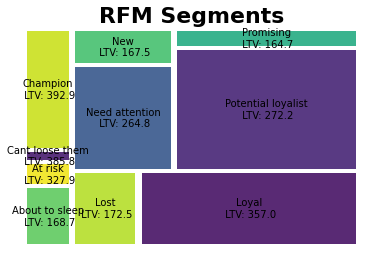

In [ ]:
# play_my_df.head()
plot_cust_segment(play_my_df,'ml_label')
# plot_cust_bar(play_my_df,'ml_label')
# plot_clv(play_my_df['LTV'])

In [ ]:
#@title campaign
from datetime import date
last_date = date(2014,10, 4)
campaign_dum_df = pd.read_csv('marketing_campaign.csv',sep=';')
campaign_dum_df['Age']=pd.to_datetime(campaign_dum_df['Dt_Customer'], dayfirst=True,format = '%Y-%m-%d')
campaign_dum_df['Age'] = pd.to_numeric(campaign_dum_df['Age'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')
campaign_dum_df['Frequency'] =  campaign_dum_df['NumWebPurchases']+campaign_dum_df['NumCatalogPurchases']+campaign_dum_df['NumStorePurchases']
campaign_dum_df['spent_total'] = campaign_dum_df['MntFruits']+campaign_dum_df['MntWines']+campaign_dum_df['MntMeatProducts']+campaign_dum_df['MntFishProducts']+campaign_dum_df['MntSweetProducts']+campaign_dum_df['MntSweetProducts']
campaign_dum_df.to_csv('market_campaign.csv',index=False)
campaign_dum_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Frequency,spent_total
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,760,22,1617
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,210,4,22
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,409,20,755
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,236,6,51
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,258,14,434


In [ ]:
#@title splitting for future time
import pandas as pd
import numpy as np
from math import ceil

def train_test_split_sorted(X, test_size, dates):
    n_test = ceil(test_size * len(X))

    sorted_index = [x for _, x in sorted(zip(np.array(dates), np.arange(0, len(dates))), key=lambda pair: pair[0])]
    train_idx = sorted_index[:-n_test]
    test_idx = sorted_index[-n_test:]

    if isinstance(X, (pd.Series, pd.DataFrame)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
    else:
        X_train = X[train_idx]
        X_test = X[test_idx]

    return X_train, X_test


In [ ]:
#@title cdnow dataset
cd_now_df = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/lifetimes/master/lifetimes/datasets/cdnow_customers_summary_with_transactions.csv')
cd_now_df.columns = ['id','frequency','recency','T','monetary_value']
cd_now_df.head()
cd_now_df.to_csv('cdnow.csv',index=False)
# cdnow = abstract_rfma_df(req_df = cd_now_df,id_col = 'id',cal_mon='monetary_value',cal_freq='frequency',age_col='T',cal_rec='recency')

# cdnow_ml = ml_segment(cdnow,recency='recency',frequency='frequency',monetary='monetary')
# cdnow.head()
# bgf,ggf = (fit_clv_model(cdnow,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
# predictions = (predict_purchase(bgf,ggf,cdnow,'uniq_rec','uniq_freq','uniq_mon','uniq_age'))
# print(f"Expected Average sales: {predictions['predicted_sales'].mean()}")
# print(f"Actual Average sales: {cdnow[cdnow['uniq_freq']>0]['uniq_mon'].mean()}")
# predictions.tail()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(k['actual'],k['predicted'])

56.44431971340489

In [ ]:
# import matplotlib.pyplot as plt
# from numpy import *
# import math
x = predictions['predicted_purchases']
y = cdnow['uniq_freq']
# # g = range(1,21)
# # k = cdnow.groupby(['uniq_freq'])[[]]
# plt.scatter(y,x,label='predcited')
# plt.show()
# plt.yscale('log')
# plt.xscale('log')
# t = linspace(0, 2*math.pi, 10)

plt.plot(y,label='predicted')
plt.plot(x,label='actual')
plt.show()

avg: 191.54


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

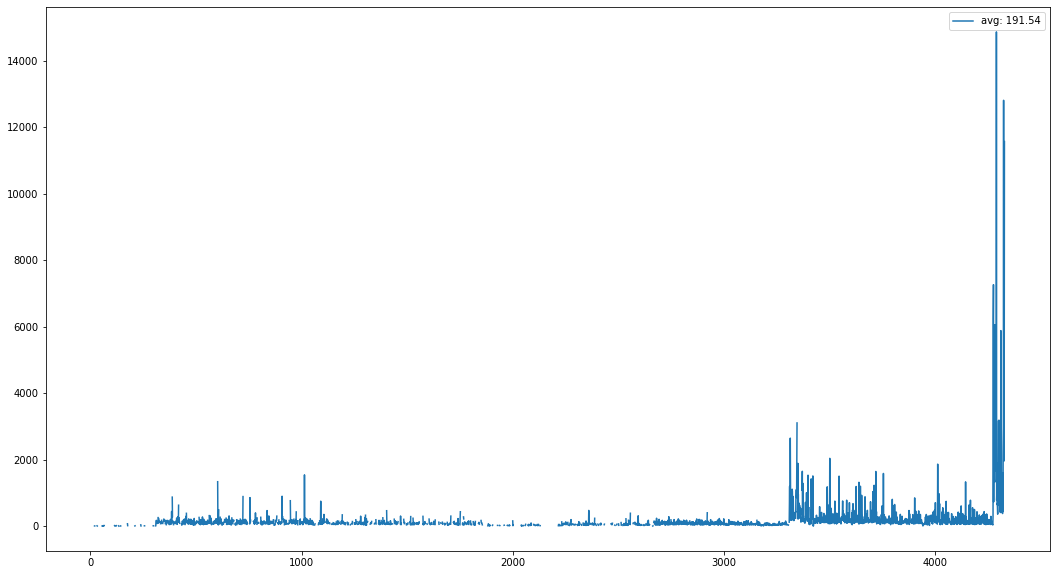

In [ ]:
# retail_dum_df = pd.read_csv('https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv')
# abc.fillna(0)
# abc.head()
# abc['total'] = abc['Quantity']*abc['UnitPrice']
# abcmon = abc.groupby(by='CustomerID', as_index=False)['total'].sum()
# abcmon.columns = ['cust_id', 'monetary']
# abcmon.head()  
# abcfreq = abc.groupby(by='CustomerID', as_index=False)['InvoiceDate'].count()
# abcfreq.columns = ['cust_id', 'frequency']
# abcnew = abcmon.merge(abcfreq,on='cust_id')
# abcnew.head()
# abcnew['first_trans']
# abc['InvoiceDate'] = pd.to_datetime(abc['InvoiceDate'],infer_datetime_format=True)
# abc['InvoiceDate'] = abc['InvoiceDate'].dt.normalize()
# abcnew['new'] = retail_df['cust_id'].apply(lambda x: retail_dum_df[retail_dum_df['CustomerID']==x].sort_values(by='InvoiceDate',ascending=True).iloc[0]['spent_total'])
# abcnew['new_val'] = (abcnew['monetary'] - abcnew['new']) / abcnew['uniq_freq']
# abcnew[['cust_id','new_val']]
# abcnew.head()

LOAD DATA

In [ ]:
df  = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/marketing_campaign.csv',sep=';')

In [ ]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
df.shape

(2240, 29)

DATA EXPLORATION


In [ ]:
df['ID'].nunique()

2240

In [ ]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [ ]:
df.describe(include='O')

,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,2012-08-31
freq,1127,864,12


*EDA*

* MISSING VALUES

In [ ]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [ ]:
def fillnulls(frame):
  for col in frame.columns:
    if (frame[col].isnull().sum()/len(frame))*100 <=30: # less than 30% of rows are null
      if frame[col].dtype == int or frame[col].dtype == float:
        frame[col].fillna(frame[col].median(),inplace=True)
      elif frame[col].dtype == object:
        frame[col].fillna(frame[col].mode()[0],inplace=True)
fillnulls(df)

UNIVARIATE ANALYSIS

26


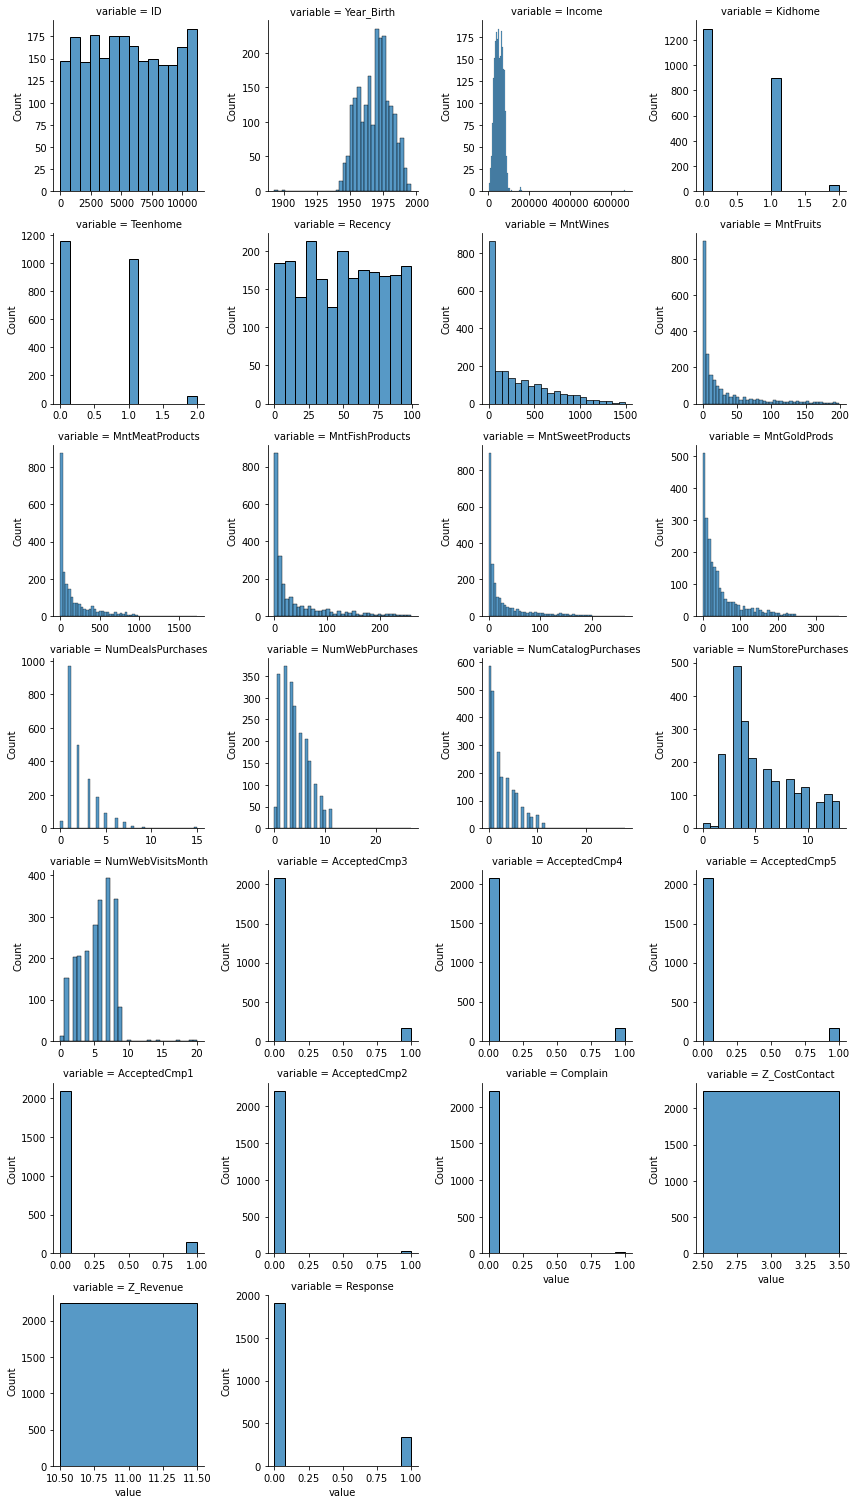

In [ ]:
cols = [i for i in df.columns if df[i].dtype!=object]
print(len(cols))
nd = pd.melt(df, value_vars =cols)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)

n1.map(sns.histplot, "value")


TARGET VARIABLE (RESPONSE)

###### data is imbalanced since target variable is not uniformly dist (50/50 or 60/40)

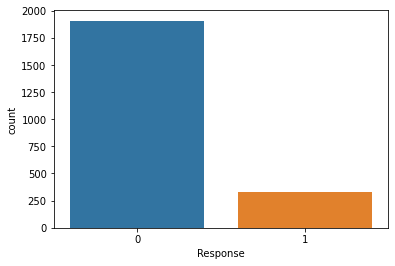

In [ ]:
sns.countplot(x = df['Response']) 

*   CORRELATION

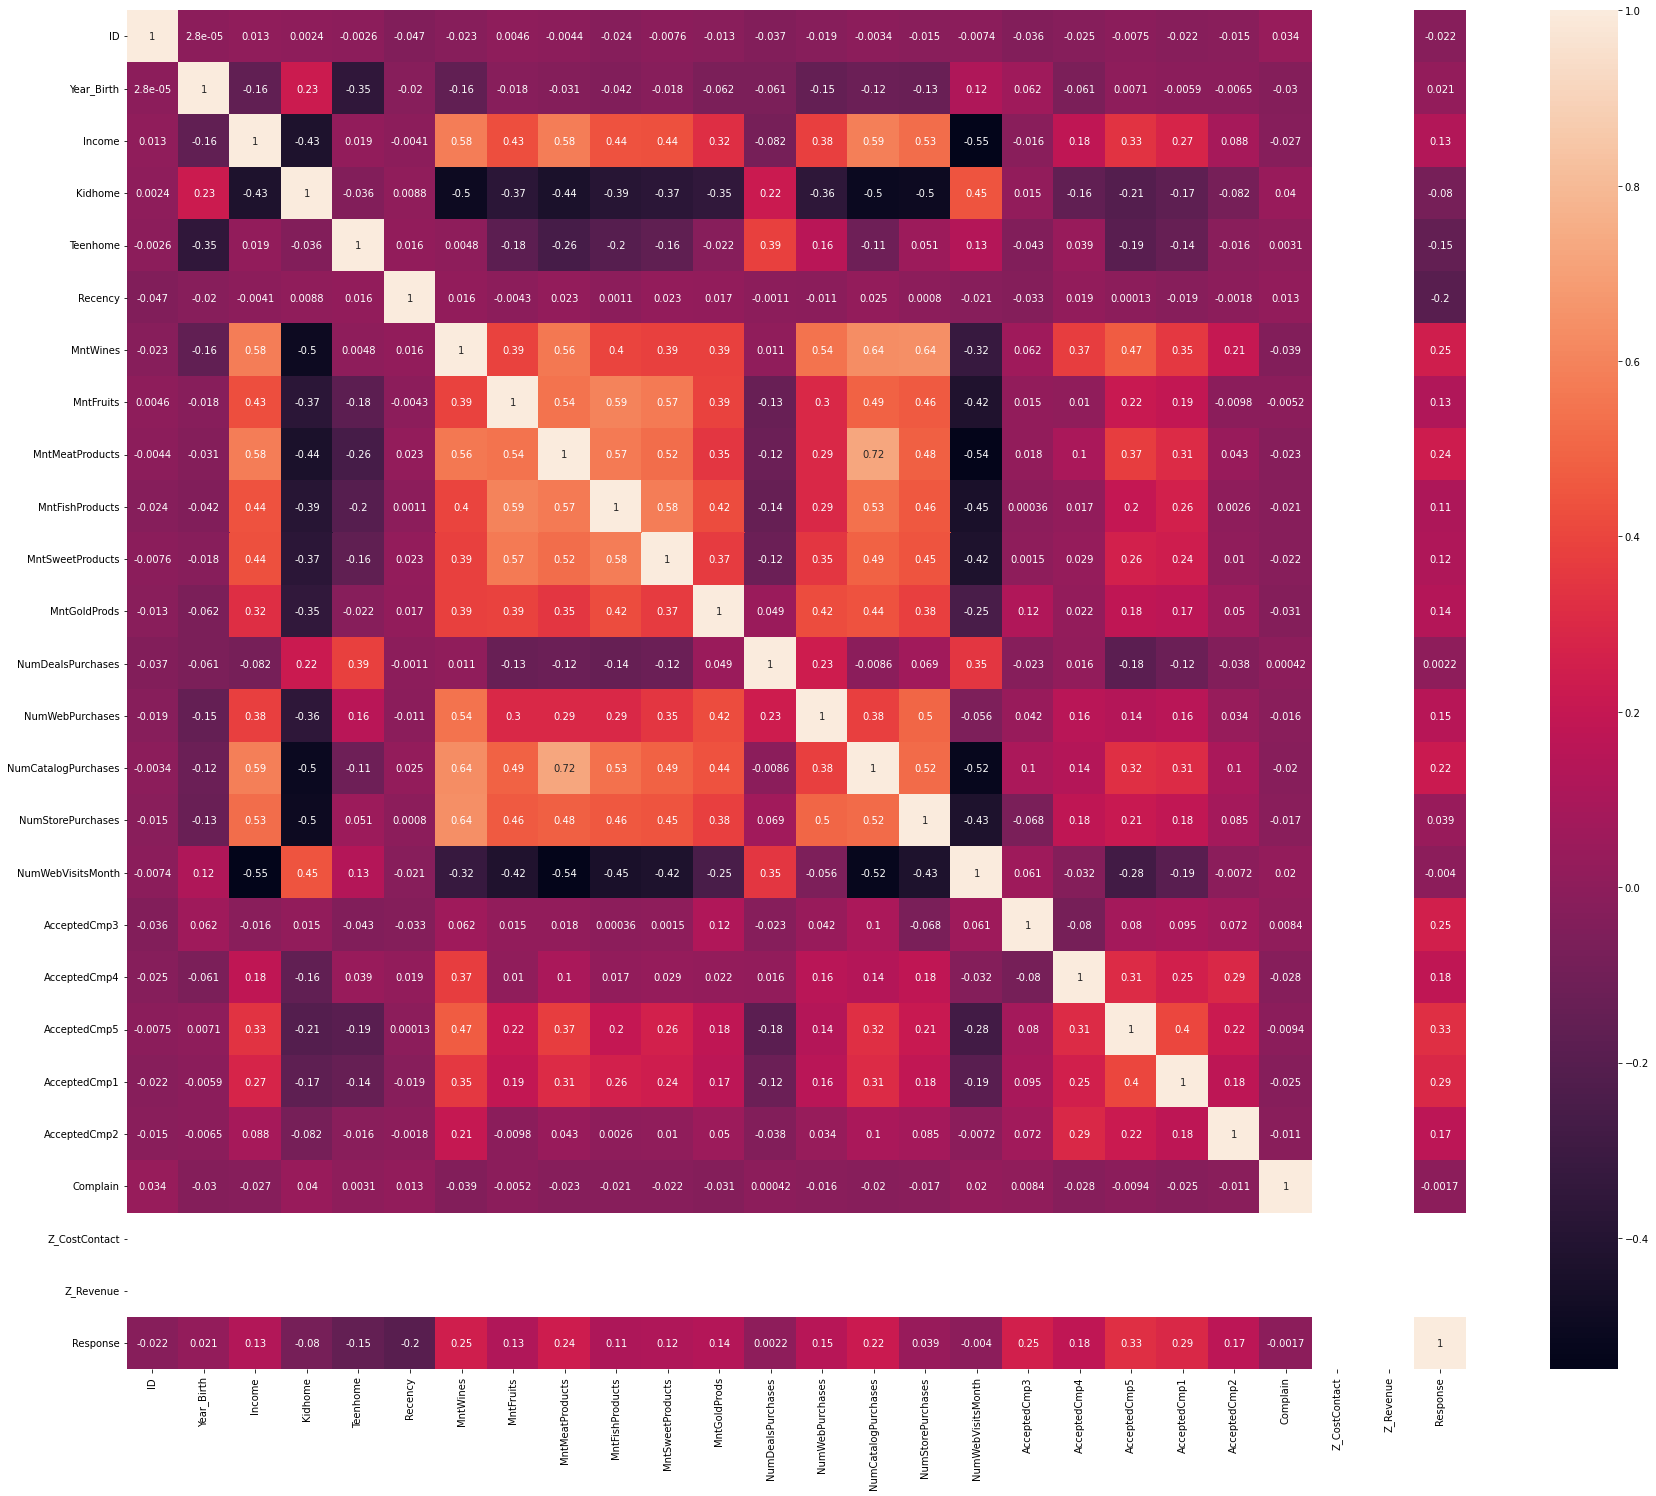

In [ ]:
plt.figure(figsize=(30,25))
sns.heatmap(data  = df.corr(),annot=True)

FEATURE ENGINEERING


*   create Age for year_birth
*   total_spent as sum of all 6 products
*   marital status changed to two: single and couple
*   educational_years for education

In [ ]:
df.head(n=8)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0


In [ ]:
#create Age for year_birth
from datetime import date
curryear = date.today().year
df['Age'] = curryear-df['Year_Birth']
df.drop(['Year_Birth'],axis=1,inplace=True)

In [ ]:
df['spent_total'] = df['MntWines']+df['MntFishProducts']+df['MntMeatProducts']+df['MntFruits']+df['MntGoldProds']+df['MntSweetProducts']
df.drop(['MntWines','MntFishProducts','MntMeatProducts','MntFruits','MntGoldProds','MntSweetProducts'],axis=1)

The relation between Education and Marital Status (Categorical Variables)
* Hypothesis (H0): There is no relation between the bith

a) Graphical Method

> Pie chart
> Barcharts

b) statistical Method
> Chi Square Test

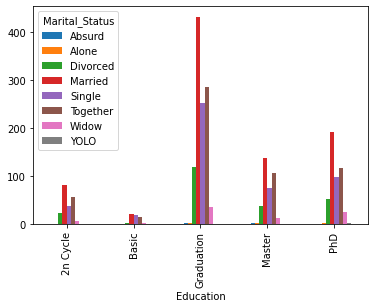

In [ ]:
Marital_Situation=df[['Education','Marital_Status']]
crosstab = pd.crosstab(Marital_Situation["Education"], Marital_Situation["Marital_Status"])
crosstab.plot(kind="bar")

In [ ]:
stat, p, dof, expected = chi2_contingency(crosstab)
print('Degress of freedom = %d' % dof)
# print(expected)
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (We reject H0)')
else:
	print('Independent (We fail to reject H0)')

Degress of freedom = 28
probability=0.950, critical=41.337, stat=27.288
Independent (We fail to reject H0)
significance=0.050, p=0.503
Independent (We fail to reject H0)


* Conclusion: The marital status and educational level are independent

In [ ]:
# df['Marital_Status'].value_counts()
mar_stat = {
    "Married":"couple",
    "Together":"couple",
    "Single":"single",
    "Divorced":"single",
    "Widow":"single",
    "Alone":"single",
    "YOLO":"single",
    "Absurd":"single"
}
df['Marital_Status'] = df['Marital_Status'].apply(lambda x: mar_stat[x])

In [ ]:
# df[df["Education"]=='2n Cycle'][["Education","Age"]]
eds = {
    "Graduation":12,
    "PhD":21,
    "Master":18,
    "2n Cycle":8,
    "Basic":5
}
df['education_yrs']=df['Education'].apply(lambda x: eds[x])
df.drop(['Education'],axis=1,inplace=True)

*  OUTLIERS DETECTION

In [ ]:
dataset = df[['Age','Income','spent_total','education_yrs']]

fig = px.box(dataset.melt(), y="value", facet_col="variable",facet_col_wrap=2, boxmode="overlay", color="variable",height=1000, width=900)
fig.update_yaxes(matches=None)

for i in range(len(fig["data"])):
    yaxis_name = 'yaxis' if i == 0 else f'yaxis{i + 1}'
    fig.layout[yaxis_name].showticklabels = True

fig.update_layout(showlegend=False)
fig.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='grey')

fig.show()

In [ ]:
#We remove the only outlier in our df before handling missing values
df = df.drop(df[df['Income']> 600000].index).reset_index(drop=True)
df.head()

In [ ]:
#Distribution of income based on education
fig = px.histogram(df, x="Income",color="education_yrs",histnorm='percent',barnorm='fraction',barmode='relative')
fig.show()

In [ ]:
data = df[['Income','education_yrs']]
category_orders={"education_yrs":["Basic","2n Cycle","Graduation","Master","PhD"]}
fig = px.histogram(df, x="education_yrs",y="Income",  histfunc='avg',category_orders=category_orders)
fig.show()

CHECKING FOR KIND OF DISTRIBUTION


1.   Graphical Method
  > Histogram plot

  > QQ plot
2.   Statistical Method

  > Shapiro Test

  > D'Agnostino and Pearson Test

  > Anderson-Darling test

  > Kolmogorov-Smirnov test

GRAPHICAL METHODS
-
   a) Histogram Plots

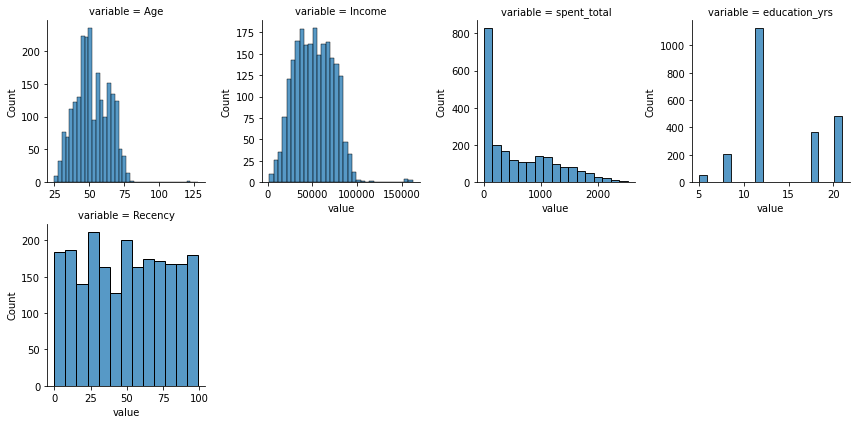

In [ ]:
nd = pd.melt(df, value_vars =['Age','Income','spent_total','education_yrs','Recency'])
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value')
n1

> The Age and Income appears to have a guassian distribution

> spent_total appears to have log distribution

> educational_yrs have multinomial distribution

   b) QQ Plot

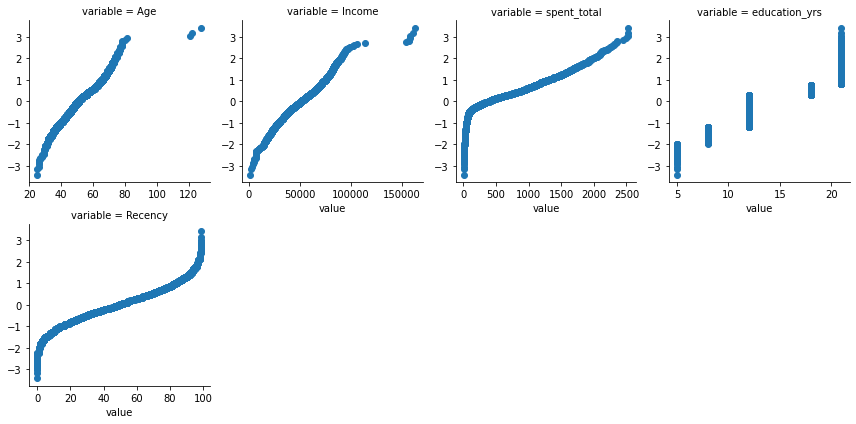

In [ ]:
nd = pd.melt(df, value_vars =['Age','Income','spent_total','education_yrs','Recency'])
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)

from scipy import stats
def quantile_plot(x, **kwargs):
    quantiles, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, quantiles, **kwargs)

n1.map(quantile_plot, "value")

> Age and Income appears to have normal dist (excluding the outliers)

In [ ]:
print("H0: The data has Guassian Distribution")
from scipy.stats import shapiro
X=['Age','Income','spent_total','education_yrs']

column_dict= {elem : pd.DataFrame() for elem in X}

def shapiro_test(data):
    stat, p = shapiro(data)
    print('%s : Statistics=%.3f, p=%.3f' % (column,stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (We fail to reject H0)')
    else:
        print('Sample does not look Gaussian (We reject H0)')

for column in X:
    column_dict[column] = df[column]
    shapiro_test(column_dict[column])  

H0: The data has Guassian Distribution
Age : Statistics=0.976, p=0.000
Sample does not look Gaussian (We reject H0)
Income : Statistics=0.976, p=0.000
Sample does not look Gaussian (We reject H0)
spent_total : Statistics=0.865, p=0.000
Sample does not look Gaussian (We reject H0)
education_yrs : Statistics=0.833, p=0.000
Sample does not look Gaussian (We reject H0)


* Conclusion: The samples doesnot have Guassian Distribution


Let us check the relation between the Income and spent_total.

 H0: The samples are uncorrelated.
> a) Graphical Methods

>> *   Scatterplot

>b) Statistical Method (non parametric tests since data is not Guassian)

>>* Spearman’s Rank Correlation.

>>* Kendall’s Rank Correlation.

>>* Goodman and Kruskal’s Rank Correlation.

>>* Somers’ Rank Correlation.

In [ ]:
from sklearn.linear_model import  LinearRegression
reg = LinearRegression().fit(np.vstack(df['spent_total']), df['Income'])
df['bestfit'] = reg.predict(np.vstack(df['spent_total']))

fig = go.Figure(data=go.Scatter(name='observations',x=df['spent_total'], y=df['Income'],mode='markers'))
fig.add_trace(go.Scatter(name='line of best fit', x=df['spent_total'], y=df['bestfit'], mode='lines'))
fig.update_traces(hovertemplate='spent_total: %{x} <br>Income: %{y}')
fig.show()

In [ ]:
from scipy.stats import spearmanr
corr, p = spearmanr(df['spent_total'], df['Income'])
print("Non-Parametric Spearman correlation test : correlation coefficient : %.4f, pval: %.4f" % (corr, p))
alpha= 0.05
if p>alpha:
  print("Accept H0")
else:
  print("Reject H0")

Non-Parametric Spearman correlation test : correlation coefficient : 0.8488, pval: 0.0000
Reject H0


Conclusion: Income and Amount spent are highly positively Correlated.

Relation Between the number of children and Income

H0: The samples are uncorrelated.

a) Graphical Methods

* PieChart

b) Statistical Method (non parametric tests since data is not Guassian)

* Spearman's Rank Correlation.

In [ ]:
from plotly.subplots import make_subplots
specs = [[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]]
fig = make_subplots(rows=1, cols=3, specs=specs)
dataset = df[['Income','Teenhome','Kidhome']].copy()
dataset['n_kids'] = dataset['Kidhome']+dataset['Teenhome']
vals = dataset['Income']
label1 = dataset['n_kids']
fig.add_trace(go.Pie(values=vals,labels=dataset['n_kids'],name='total kids'),1,1)
fig.add_trace(go.Pie(values=vals,labels=dataset['Kidhome'],name='kids'),1,2)
fig.add_trace(go.Pie(values=vals,labels=dataset['Teenhome'],name=' teens'),1,3)
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Income vs Children ( The distribution remains same in total of kids and teen)",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='total kids', x=0.099, y=0.5, font_size=20, showarrow=False),
                 dict(text='kids', x=0.499, y=0.5, font_size=20, showarrow=False),
                 dict(text='teens', x=0.89, y=0.5, font_size=20, showarrow=False),
                 ])
fig.show()


In [ ]:
from scipy.stats import spearmanr
corr, p = spearmanr(df['Kidhome']+df['Teenhome'], df['Income'])
print('Spearmans correlation coeff: %.3f' % corr)
print("Non-Parametric Spearman correlation test : correlation coefficient : %.4f, pval: %.4f" % (corr, p))
alpha= 0.05
if p>alpha:
  print("Accept H0: Samples are uncorrelated")
else:
  print("Reject H0:Samples are uncorrelated")

Spearmans correlation coeff: -0.374
Non-Parametric Spearman correlation test : correlation coefficient : -0.3739, pval: 0.0000
Reject H0:Samples are uncorrelated


* Slight negative correlation can be seen as the number of children increases the income decreases.

In [ ]:
df['n_kids'] = df['Teenhome']+df['Kidhome']
df.drop(['Teenhome','Kidhome'],inplace=True,axis=1)
no = df[(df['n_kids']>0) & (df['Response']==1)].shape[0]
all = df[(df['n_kids']==0) & (df['Response']==1)].shape[0]
dec = "no Kids" if no>all else "kids"
print(f"People with {dec} had better Response rate")

People with kids had better Response rate


In [ ]:
df.columns

Index(['ID', 'Marital_Status', 'Income', 'Dt_Customer', 'Recency',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Age',
       'spent_total', 'education_yrs', 'bestfit', 'n_kids'],
      dtype='object')

In [ ]:
# most succesful campaigns
freq_campaign = df[[ 'AcceptedCmp1', 'AcceptedCmp2',
                    'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5']].sum(axis=0)
px.bar(y = freq_campaign,title = 'Most succesful campaign')

- Creating dataset for RFM model
- Dropping customers with less than two transactions and zero spendings

In [ ]:
df['Transactions'] = df['NumDealsPurchases']+df['NumWebVisitsMonth']+df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']
df['spent_total'] = df['MntWines']+df['MntFishProducts']+df['MntMeatProducts']+df['MntFruits']+df['MntGoldProds']+df['MntSweetProducts']
df.drop(['MntWines','MntFishProducts','MntMeatProducts','MntFruits','MntGoldProds','MntSweetProducts'],axis=1)
dataset = df[['ID','Transactions','spent_total','Recency','Dt_Customer']]

In [ ]:
dataset.head()

,ID,Transactions,spent_total,Recency,Dt_Customer
0,5524,32,1617,58,2012-09-04
1,2174,11,27,38,2014-03-08
2,4141,25,776,26,2013-08-21
3,6182,14,53,26,2014-02-10
4,5324,24,422,94,2014-01-19


In [ ]:
needed = dataset.rename(columns={'ID':'id','Transactions':'frequency','spent_total':'monetary','Recency':'recency','Dt_Customer':'dt_customer'})
# needed.to_csv('campaigns.csv',index=False)

In [ ]:
print("Number of Transactions:",dataset['Transactions'].sum())
print("Total amount spent by customers:",dataset['spent_total'].sum())
print("number of customers:",dataset['ID'].nunique())

Number of Transactions: 45200
Total amount spent by customers: 1356988
number of customers: 2240


In [ ]:
dataset = dataset[(dataset['Transactions']>1)& (dataset['spent_total']>0)]

- Recency

In [ ]:
recen = dataset[['ID','Recency']]

- Frequency

In [ ]:
freq = dataset[['ID','Transactions']]

- Monetary

In [ ]:
mon = dataset[['ID','spent_total']]

- Aggregation

In [ ]:
temp_df = recen.merge(freq,on='ID')
rfm_df = temp_df.merge(mon,on='ID')
rfm_df.columns = ['ID','RECENCY','FREQUENCY','MONETARY']

In [ ]:
rfm_df.head()

,ID,RECENCY,FREQUENCY,MONETARY
0,5524,58,32,1617
1,2174,38,11,27
2,4141,26,25,776
3,6182,26,14,53
4,5324,94,24,422


In [ ]:
rfm_df.isnull().sum()

ID           0
RECENCY      0
FREQUENCY    0
MONETARY     0
dtype: int64

# RFM SCORES


In [ ]:
px.histogram(data_frame=rfm_df,x= 'RECENCY')

specs = [[{'type':'xy'}, {'type':'xy'},{'type':'xy'}]]
fig = make_subplots(rows=1, cols=3,specs  =specs)
dataset = rfm_df[['RECENCY','FREQUENCY','MONETARY']].copy()
fig.add_trace(go.Histogram(x=rfm_df['RECENCY']),1,1)
fig.add_trace(go.Histogram(x=rfm_df['FREQUENCY']),1,2)
fig.add_trace(go.Histogram(x=rfm_df['MONETARY']),1,3)
fig.update_layout(
    title_text="Distribution of RFM",
    # Add annotations in the center of the donut Histograms.
)
fig.show()


NameError: ignored

In [ ]:
rfm_df['f_score'] = pd.qcut(rfm_df['FREQUENCY'],q=5,labels=range(1,6))
rfm_df['r_score'] = pd.qcut(rfm_df['RECENCY'],q=5,labels=range(1,6))
rfm_df['m_score'] = pd.qcut(rfm_df['MONETARY'],q=5,labels=range(1,6))
rfm_df['rfm_score'] = rfm_df['f_score'].astype(str)+rfm_df['r_score'].astype(str)+rfm_df['m_score'].astype(str)
# rfm_df.drop(['r_score','f_score','m_score'],inplace=True,axis=1)

* Here the maximum score would be 444 and minimum would be 111 and at 64 unique scores

In [ ]:
dataset = rfm_df.copy()
dataset['Response'] = df['Response']
dataset['rfm_score']=dataset['rfm_score'].astype(int)
px.histogram(data_frame=dataset,x='rfm_score',color='Response',barmode='group')

* The rfm score of maximum positve responses were between 420 to 432.
* rfm score of 111 are highly engaged customers (CHAMPIONS CUSTOMERS).
* rfm score of x1x are the customers who buys often (LOYAL CUSTOMERS).
* rfm score of XX1  have generated the most revenue for your store(CAN'T LOSE THEM).
* rfm score of X13, X14 are the customers who return often, but do not spend a lot(PROMISING/FAITHFUL CUSTOMERS)
* rfm score of 14X are the new customers(ROOKIES).

In [ ]:
needed['new_label'].value_counts()

In [ ]:
import re
needed['f_score'] = pd.qcut(needed['frequency'],q=5,labels=range(0,5))
needed['r_score'] = pd.qcut(needed['recency'],q=5,labels=range(0,5))
needed['m_score'] = pd.qcut(needed['monetary'],q=5,labels=range(0,5))
needed['rfm_score'] = needed['f_score'].astype(str)+needed['r_score'].astype(str)+needed['m_score'].astype(str)
conds = {
         r'44.':'Champions',
         r'[2,3,4][3,4].':'Loyal',
         r'[3,4][1,2].':'Potential Loyal',
         r'[1,2][1,2].':'Need Attention',
         r'41.':'New Customers',
         r'21.':'Hibernating',
         r'[1,0]4.':'Cant Loose',
         r'[1,0][1,0].':'Lost',
         r'[1,0][2,3].':'At Risk',
         r'40.':'New Customers'
}
needed['Label'] = needed['rfm_score'].astype(str).replace(conds,regex=True)
needed['Label'].value_counts()
# needed['Label'] = needed['r_score'].astype(str)+needed['f_score'].astype(str)
# needed['new_label'] = needed['Label'].replace(conds,regex=True)
# needed['new_label'].value_counts()

Loyal              441
Need Attention     362
Potential Loyal    337
Lost               292
At Risk            277
Cant Loose         190
Champions           77
New Customers       69
302                 42
304                 34
202                 32
204                 30
303                 27
201                 16
203                 13
200                  1
Name: Label, dtype: int64

In [ ]:
data.head()

,Name,Number
0,a,3
1,b,2
2,c,1
3,d,0


In [ ]:

df.head()

,new_label,label
Loyal customers,441,Loyal customers
Need attention,362,Need attention
Potential loyalist,349,Potential loyalist
Lost,292,Lost
At risk,277,At risk


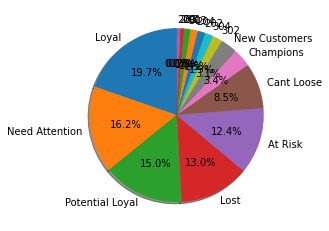

In [ ]:
k = dict(needed['Label'].value_counts())
label = [i for i in k.keys()]
values = [i for i in k.values()]
colors = sns.color_palette('pastel')[0:len(values)]
plt.pie(data=needed['Label'].value_counts().reset_index(),x=values,labels=label,autopct='%1.1f%%',shadow=True, startangle=90)
plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd

data = {'Name': ['a', 'b', 'c', 'd'], 'Number': [3, 2, 1, 0], }
data = pd.DataFrame.from_dict(data)

parents = ['']*len(data['Name'])

fig1 = go.Figure(go.Treemap(labels=data['Name'], values=data['Number'], parents=parents))
fig1.show()


In [ ]:
df = pd.DataFrame.from_dict(needed['new_label'].value_counts())
parents = ['']*(data.shape[0])
df['label'] = df.index
# fig = px.treemap(data_frame=needed,path=df.columns,values=df.iloc[0])
# fig1 = go.Figure(go.Treemap(labels=df['label'], values=df['new_label'], parents=parents))
# fig1.show()
fig = px.treemap(df, 
                 path=['label'], 
                 values='new_label',
                )
fig.show()
# fig.show()
# df = px.data.gapminder().query("year == 2007")
# fig = px.treemap(df, path=[px.Constant("world"), 'continent', 'country'], values='pop',
#                   color='lifeExp', hover_data=['iso_alpha'],
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

In [ ]:
  fig = px.pie(dataset,values='rfm_score',names='Label',title='Customer segments on RFM scores',)
fig.update_traces(hoverinfo='percent', textinfo='percent', textfont_size=10)
fig.show()

In [ ]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

In [ ]:
X.head()

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'FREQUENCY',y = 'RECENCY',hue="label",  
                 palette=['green','orange','brown','dodgerblue','red'], legend='full',data = X  ,s = 60 )
plt.xlabel('FREQUNCY')
plt.ylabel('RECENY') 
plt.title('FREQ VS RECEN')
plt.show()

Usually at this stage we would define segments based on business knowledge and the sum of the RFM scores.

A different approach using K-Means to find clusters will be followed.

# K-Means Clustering

The data will be preprocessed so K-Means have a better chance to converge to an optimal solution.

The number of clusters will be found using the elbow-method with the silhouette score as the metric of evaluation.

An analysis of the clusters and how they behave will be done later on


### Preprocessing

* Data will be processed to satisfy K-Means assumptions which are:
    * Symmetric distributions of variables (not skewed)
    * Variables with same average values. This makes ensures that each metric receives an equal weight in the K-Means calculation.
    * Variables with same variance, this also ensures equal importance in the clustering calculation.

In [ ]:
rfm_df.head()

,ID,RECENCY,FREQUENCY,MONETARY
0,5524,58,32,1617
1,2174,38,11,27
2,4141,26,25,776
3,6182,26,14,53
4,5324,94,24,422


In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# rfmdf = rfm_df.drop(['rfm_score','r_score','f_score','m_score'],axis=1).astype(int)
rfmdf = rfm_df.drop(['rfm_score'],axis=1,errors='ignore').astype(int)
# for i in rfmdf.columns:
#   rfmdf[i] = np.log1p(rfmdf[i])
# rfmdf[['RECENCY','FREQUENCY','MONETARY']] = scaler.fit_transform(rfm_df[['RECENCY','FREQUENCY','MONETARY']])

In [ ]:
# px.histogram(data_frame=rfmdf,x= 'RECENCY')

specs = [[{'type':'xy'}, {'type':'xy'},{'type':'xy'}]]
fig = make_subplots(rows=1, cols=3,specs  =specs)
dataset = rfmdf[['RECENCY','FREQUENCY','MONETARY']].copy()
fig.add_trace(go.Histogram(x=rfmdf['RECENCY']),1,1)
fig.add_trace(go.Histogram(x=rfmdf['FREQUENCY']),1,2)
fig.add_trace(go.Histogram(x=rfmdf['MONETARY']),1,3)
fig.update_layout(
    title_text="Distribution of RFM",
    # Add annotations in the center of the donut Histograms.
)
fig.show()


In [ ]:
'''
#@title Useless For Large Samples
'''

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

def shapiro_test(data_frame):
  result = []
  for col_name in data_frame.columns:
    print(f'Sharipo-Wilk test for {col_name}')
    stat, p = shapiro(data_frame[col_name])
    print(f'Statistics={stat}, p={p} of {col_name} distribution')

    alpha = 0.05
    if p > alpha:
        print(f'Sample of {col_name} looks normal (fail to reject H0) with Sharipo-Wilk Test')
        result.append(True)
    else:
        print(f'Sample of {col_name} does not look Gaussian (reject H0) with Sharipo-Wilk Test \n\n')
        result.append(False)
  return result
def agnostic_test(data_frame):
  result=[]
  for col_name in data_frame.columns:        
    print(f'D’Agostino’s K^2 test for {col_name}')
    stat, p = normaltest(data_frame[col_name])
    print('Statistics=%.3f, p=%.3f of %s distribution' % (stat, p, col_name))

    alpha = 0.05
    if p > alpha:
        print(f'Sample of {col_name} looks normal (fail to reject H0) with D’Agostino’s K^2 Test')
        result.append(True)
    else:
        print(f'Sample of {col_name} does not look normal (reject H0) with D’Agostino’s K^2 Test \n\n')
        result.append(True)
  return result
def anderson_test(data_frame):
  for col_name in data_frame.columns:         
    print(f'Anderson-Darling test for {col_name}')
    
    result = anderson(data_frame[col_name])
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0) with Anderson-Darling test \n\n' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0) with Anderson-Darling test \n\n' % (sl, cv))

In [ ]:
print(rfmdf.columns,rfmdf.shape)
shapiro_test(rfmdf[:20])

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot_data = qqplot(rfmdf['MONETARY'], line='s').gca().lines

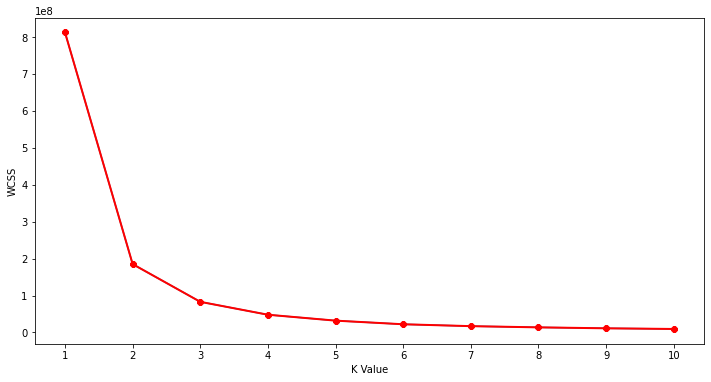

In [ ]:
# # Instantiate the clustering model and visualizer
# from sklearn.model_selection import KMeans
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    km=KMeans(n_clusters=i)
    # km.fit(rfmdf)
    km.fit(rfmdf.drop('ID',axis=1))
    wcss.append(km.inertia_)

#The elbow curve
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [ ]:
!pip install yellowbrick

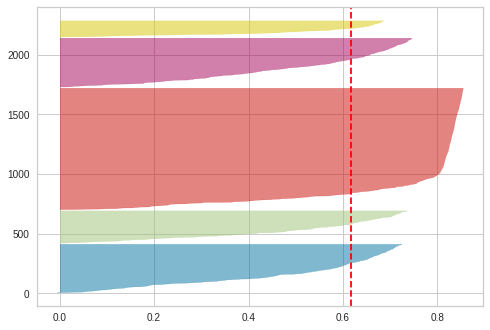

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# clusters_range = range(2,15)
# random_range = range(0,20)
# results =[]
# for c in clusters_range:
#     for r in random_range:
#         clusterer = KMeans(n_clusters=c, random_state=r)
#         cluster_labels = clusterer.fit_predict(rfmdf)
#         silhouette_avg = silhouette_score(rfmdf, cluster_labels)
#         print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
#         results.append([c,r,silhouette_avg])

# result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
# pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

# plt.figure(figsize=(15,6))
# sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
# plt.tight_layout()
from sklearn.cluster import KMeans

# from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer
X=rfmdf.drop('ID',axis=1)

# Use the quick method and immediately show the figure

model = SilhouetteVisualizer(KMeans(5, random_state=42),colors='yellowbrick')
model.fit(X)
plt.show()

In [ ]:
X=rfmdf.drop(['ID'],axis=1)
X.head()

,RECENCY,FREQUENCY,MONETARY
0,58,32,1617
1,38,11,27
2,26,25,776
3,26,14,53
4,94,24,422


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
#Taking 5 clusters
km1=KMeans(n_clusters=5,init='k-means++',n_init=50,max_iter=500,random_state=42)
#Fitting the input data
km1.fit(scaled)
#predicting the labels of the input data
y=km1.predict(scaled)
#adding the labels to a column named label
X["label"] = y
#The new dataframe with the clustering done
X.head()

,RECENCY,FREQUENCY,MONETARY,label
0,58,32,1617,0
1,38,11,27,2
2,26,25,776,4
3,26,14,53,1
4,94,24,422,3


Taking 3 thing in consideration

In [ ]:
clus_0 = X[X.label==0]
clus_1 = X[X.label==1]
clus_2 = X[X.label==2]
clus_3 = X[X.label==3]
clus_4 = X[X.label==4]


In [ ]:
dic = {'clus_0':clus_0.mean(),
       'clus_1':clus_1.mean(),
       'clus_2':clus_2.mean(),
       'clus_3':clus_3.mean(),
       'clus_4':clus_4.mean(),}
for i,y in dic.items():
  print(i,y)
  print('-------------')

clus_0 RECENCY        73.644033
FREQUENCY      25.858025
MONETARY     1217.810700
label           0.000000
dtype: float64
-------------
clus_1 RECENCY       15.452703
FREQUENCY     15.916667
MONETARY     168.700450
label          1.000000
dtype: float64
-------------
clus_2 RECENCY       47.940774
FREQUENCY     16.517084
MONETARY     196.359909
label          2.000000
dtype: float64
-------------
clus_3 RECENCY       82.537757
FREQUENCY     15.665904
MONETARY     159.164760
label          3.000000
dtype: float64
-------------
clus_4 RECENCY        23.245940
FREQUENCY      26.607889
MONETARY     1236.146172
label           4.000000
dtype: float64
-------------


In [ ]:
texts = [f'Recency:{round(dic[i][1],2)}\Frequency:{round(dic[i][2],2)}\Monetary:{round(dic[i][3],2)}' for i in sorted(dic.keys())]
print(texts)

['Recency:25.86\\Frequency:1217.81\\Monetary:0.0', 'Recency:15.92\\Frequency:168.7\\Monetary:1.0', 'Recency:16.52\\Frequency:196.36\\Monetary:2.0', 'Recency:15.67\\Frequency:159.16\\Monetary:3.0', 'Recency:26.61\\Frequency:1236.15\\Monetary:4.0']


In [ ]:
#Distribution of income based on education
labels = ['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4']
values = [len(X[X.label==0]),len(X[X.label==1]),len(X[X.label==2]),len(X[X.label==3]),len(X[X.label==4])]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,hovertext=texts,textinfo='label+percent')])
fig.show()

In [ ]:
#Distribution of income based on education
labels = ['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4']
values = [len(X[X.label==0]),len(X[X.label==1]),len(X[X.label==2]),len(X[X.label==3]),len(X[X.label==4])]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,hovertext=texts,textinfo='label+percent')])
fig.show()

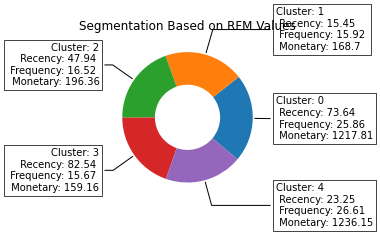

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = []
cluster_count = 0
for k in dic.values():
    r = f'Cluster: {cluster_count}\n Recency: {round(k[0],2)} \n Frequency: {round(k[1],2)} \n Monetary: {round(k[2],2)}'
    cluster_count+=1
    recipe.append(r)
data = [len(X[X.label==0]),len(X[X.label==1]),len(X[X.label==2]),len(X[X.label==3]),len(X[X.label==4])]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Segmentation Based on RFM Values")

plt.show()

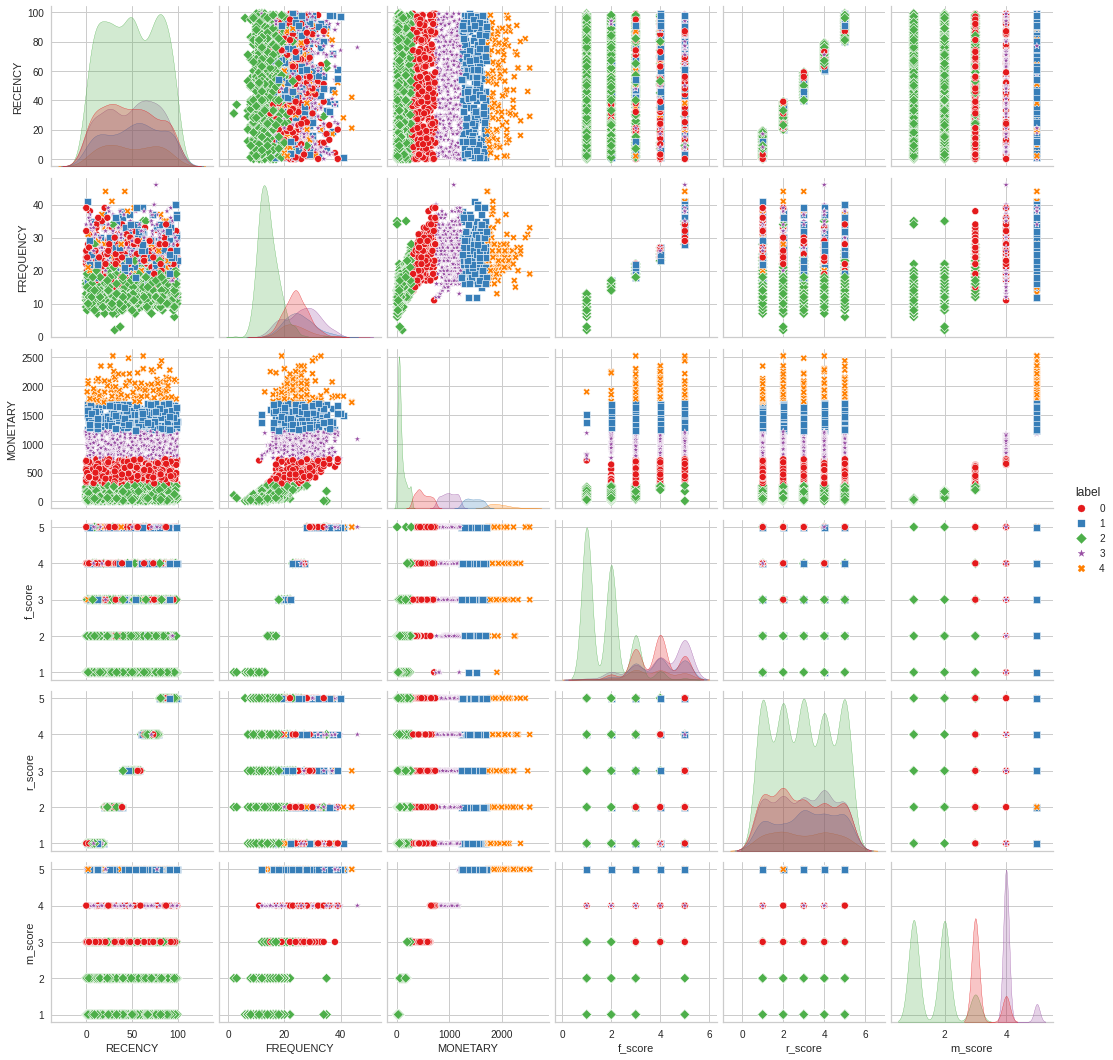

In [ ]:
# dd = X.drop(['ID'],axis=1).astype(int)
# sns.pairplot(X, hue="label", markers=["o", "s", "D", "*","X","p"], 
#              palette=sns.color_palette('Set1', n_colors=6))
# plt.show()
sns.pairplot(X, hue="label", markers=["o", "s", "D", "*","X"], 
             palette=sns.color_palette('Set1', n_colors=5))

In [ ]:
X['label'].value_counts()

0    486
1    444
2    439
3    437
4    431
Name: label, dtype: int64

In [ ]:
rfmdf.head()

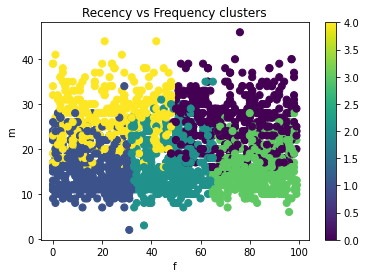

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X['RECENCY'], X['FREQUENCY'], c=X['label'], s=50)
                    
ax.set_title('Recency vs Frequency clusters')
ax.set_xlabel('f')
ax.set_ylabel('m')
plt.colorbar(scatter)

# LTV (CUSTOMER LIFETIME VALUE)

In [ ]:
dataset.head()

,ID,Transactions,spent_total,Recency,Dt_Customer
0,5524,32,1617,58,2012-09-04
1,2174,11,27,38,2014-03-08
2,4141,25,776,26,2013-08-21
3,6182,14,53,26,2014-02-10
4,5324,24,422,94,2014-01-19


In [ ]:
!pip install Lifetimes

     |████████████████████████████████| 584 kB 5.1 MB/s 


In [ ]:
rfm_df.shape,df.shape

((2237, 4), (2240, 31))

In [ ]:
rfm_df['Dt_Customer'] =  df['Dt_Customer']

In [ ]:
clv_df = rfm_df[['ID']]
clv_df['Dt_Customer']=rfm_df['Dt_Customer']
clv_df['monetary'] = rfm_df['MONETARY']/rfm_df['FREQUENCY']

In [ ]:
clv_df.head()

,ID,Dt_Customer,monetary
0,5524,2012-09-04,50.531250
1,2174,2014-03-08,2.454545
2,4141,2013-08-21,31.040000
3,6182,2014-02-10,3.785714
4,5324,2014-01-19,17.583333


In [ ]:
clv_df[clv_df['monetary']==0.0]

,ID,Dt_Customer,monetary


In [ ]:
clv_df.isnull().sum()

ID             0
Dt_Customer    0
dtype: int64

In [ ]:
from datetime import datetime
last_date = datetime.strptime(max(rfm_df['Dt_Customer']),'%Y-%m-%d').date()

In [ ]:
clv_df['AGE'] = pd.to_datetime(rfm_df['Dt_Customer'],dayfirst=True,format = '%Y-%m-%d')
clv_df['AGE'] = pd.to_numeric(clv_df['AGE'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')
#Average moneatary value of each customer
clv_df['MONETARY']=rfm_df['MONETARY']/rfm_df['FREQUENCY']
#Frequency is after the first purchase
clv_df['FREQUENCY']=rfm_df['FREQUENCY']-1
clv_df['RECENCY']=(clv_df['AGE']-rfm_df['RECENCY'])
clv_df.head()

In [ ]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.5)
bgf.fit(clv_df['FREQUENCY'], clv_df['RECENCY'], clv_df['AGE'])
print(bgf.summary())

In [ ]:
from lifetimes.utils import summary_data_from_transaction_data
summary = summary_data_from_transaction_data(df, 'ID', 'Dt_Customer')

print(summary.head())
print(summary.describe())


    frequency  recency      T
ID                           
0         0.0      0.0  421.0
1         0.0      0.0   14.0
9         0.0      0.0  680.0
13        0.0      0.0  342.0
17        0.0      0.0  296.0
       frequency  recency            T
count     2240.0   2240.0  2240.000000
mean         0.0      0.0   353.582143
std          0.0      0.0   202.122512
min          0.0      0.0     0.000000
25%          0.0      0.0   180.750000
50%          0.0      0.0   355.500000
75%          0.0      0.0   529.000000
max          0.0      0.0   699.000000


In [ ]:
summary.describe()

,frequency,recency,T,monetary_value
count,2237.0,2237.0,2237.000000,2237.000000
mean,1.0,0.0,353.639249,26.147914
std,0.0,0.0,202.091568,25.748098
min,1.0,0.0,0.000000,0.228571
25%,1.0,0.0,181.000000,5.000000
50%,1.0,0.0,356.000000,17.153846
75%,1.0,0.0,529.000000,38.900000
max,1.0,0.0,699.000000,150.133333


In [ ]:
df.head()